# Load Dependencies

## Install Libraries 

In [17]:
!pip install pandas --break-system-packages
!pip install librosa --break-system-packages
!pip install pyloudnorm --break-system-packages
!pip install tensorflow tensorflow-io --break-system-packages
!pip install pydub --break-system-packages

## Import Libaries

In [1]:
import os
import shutil
import uuid
import pandas as pd
import math
import numpy as np
from pydub import AudioSegment, silence
import librosa as lb
import warnings
import pyloudnorm as pyln
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_io as tfio

/usr/local/lib/python3.11/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
2023-09-05 22:30:12.624734: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 22:30:12.957276: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 22:30:12.959224: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 22:30:14.303775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data Import

## File Paths

In [159]:
# return list of files for of given folder
def get_files(path: str, file_formats: list, exclude_dirs: list = []):
    filtered_files=[]
    for root, dirs, files in os.walk(path, topdown=True):
        if root not in exclude_dirs:
            for file in files:
                file_name, file_extension = os.path.splitext(file)
                file_path = root + "/" + file
                if file_extension in file_formats:
                    filtered_files.append(file_path)
                    # convert wav stereo to mono 
                    sound = AudioSegment.from_wav(file_path)
                    sound = sound.set_channels(1)
                    sound.export(file_path, format="wav")
                else:
                    # remove none wave files
                    os.remove(file_path)
                    print(root, file_name)
    return filtered_files

In [162]:
dir = "/home/helsfyr2_with_9_dbfs+/"
neg_dir= "/home/helsfyr2_with_9_dbfs/neg"
file_formats= ['.wav']

In [20]:
pos_files = get_files(dir, file_formats, [neg_dir])
neg_files = get_files(neg_dir, file_formats)

del dir, neg_dir, file_formats

In [163]:

files = get_files(dir, file_formats, [])

### Copy files in label folder structure

In [21]:
# for pos_file in pos_files:
#     file_name =  os.path.basename(pos_file)
#     shutil.copyfile(pos_file, '/home/data/announcement/' + file_name)

In [22]:
# for neg_file in neg_files:
#     file_name =  os.path.basename(neg_file)
#     shutil.copyfile(neg_file, '/home/data/no announcement/' + file_name)

# Data Preperation

## Audio normalization

In [23]:
target_sr: int = 16000
target_loudness: float = -12.0

In [24]:
def audio_normalization(y: np.ndarray, sr: int):
    #Convert to mono
    y = lb.to_mono(y=y)

    #set sampling rate
    y = lb.resample(y=y, orig_sr=sr, target_sr=target_sr)

    #Normalize loudness
    with warnings.catch_warnings(record=True):
        meter = pyln.Meter(rate=target_sr)
        loudness = meter.integrated_loudness(data=y)
        y = pyln.normalize.loudness(data=y, input_loudness=loudness, target_loudness=target_loudness)
    return y

In [228]:
def audio_normalization2(y):
    #Convert to mono
    sr = 16000
    # y = lb.to_mono(y=y)

    print(y)
    #set sampling rate
    y = lb.resample(y=y, orig_sr=sr, target_sr=target_sr)

    #Normalize loudness
    with warnings.catch_warnings(record=True):
        meter = pyln.Meter(rate=target_sr)
        loudness = meter.integrated_loudness(data=y)
        y = pyln.normalize.loudness(data=y, input_loudness=loudness, target_loudness=target_loudness)
    return y

## Mel diagram

In [26]:
def log_melspectogram(y: np.array, sr: int):
    y = audio_normalization(y=y, sr=sr)
    S = lb.feature.melspectrogram(y=y, sr=sr ,n_mels=128)
    return lb.power_to_db(S=S, ref=np.max)

In [27]:
def file_log_melspectograms(file_path:str, duration: float, offset: float):
    y, sr = lb.load(file_path)
    duration_total = lb.core.get_duration(y=y, sr=sr)
    S = []
    #Slicing
    for i in np.arange(0.0, duration_total-offset, offset):
        y = lb.load(file_path, mono=True, offset=i, duration=duration)[0]
        s=log_melspectogram(y=y, sr=sr)
        S.append(s)
    return np.array(S)

In [28]:
def files_log_melspectograms(file_paths:list, duration: float, offset: float):
    data_pos=[]
    for file_path in file_paths:
        for s in file_log_melspectograms(file_path=file_path, duration=duration, offset=offset):
            data_pos.append(s)
    return np.array(data_pos)

## Load data

In [29]:
def load_data_category(file_paths: list, label: str, duration:float, offset:float):
    data = files_log_melspectograms(file_paths=file_paths, duration=duration, offset=offset)
    label = np.array([label for i in range(len(data))])
    return data, label

In [30]:
#TODO  Iteration need to start from here
duration: float = 2.0

#TODO solve [src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (800) too large for available bit count (760)
pos_data, pos_label = load_data_category(file_paths=pos_files[:100], label='announcement', duration=duration, offset=duration)
neg_data, neg_label = load_data_category(file_paths=neg_files[:250], label='no announcement', duration=duration, offset=duration)

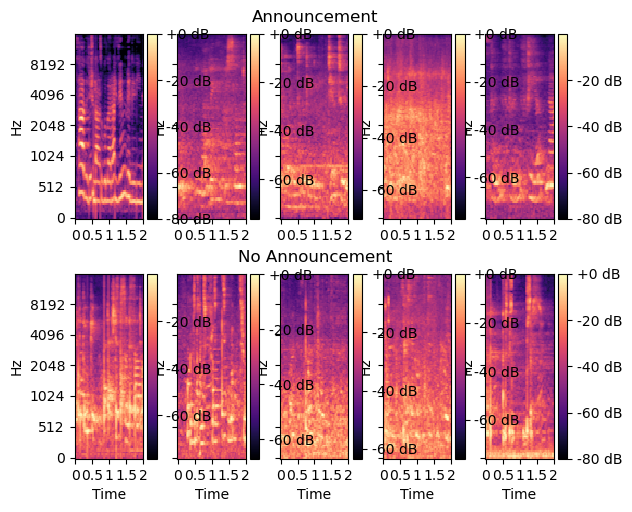

In [31]:
random.seed(42)
n=5

fig = plt.figure()
fig.suptitle('Figure title')
subfigs = fig.subfigures(nrows=2, ncols=1)
subfig_pos=subfigs[0]
subfig_neg=subfigs[1]
subfig_pos.suptitle('Announcement')
subfig_neg.suptitle('No Announcement')
axs_pos = subfig_pos.subplots(nrows=1, ncols=n, sharex=True, sharey= True)
axs_neg = subfig_neg.subplots(nrows=1, ncols=n, sharex=True, sharey= True)

for i in range(n):
    S_pos = random.choice(pos_data)
    S_neg = random.choice(neg_data)
    ax_pos = axs_pos[i]
    ax_neg = axs_neg[i]
    
    # Display spectrograms
    img_pos = lb.display.specshow(data=S_pos, x_axis='time', y_axis='mel', sr=target_sr, fmax=target_sr, ax=ax_pos)
    img_neg = lb.display.specshow(data=S_neg, x_axis='time', y_axis='mel', sr=target_sr, fmax=target_sr, ax=ax_neg)
    fig.colorbar(img_pos, ax=ax_pos, format='%+2.0f dB')
    fig.colorbar(img_neg, ax=ax_neg, format='%+2.0f dB')

plt.show()

#TODO save plot for each experiment

del n, fig, subfigs, subfig_pos, subfig_neg, axs_pos, axs_neg, i, S_pos, S_neg, ax_pos, ax_neg, img_pos, img_neg

In [32]:
#ensure that percentage of positive and negative data sets is maintained
pos_size = 0.5

data_size = 2 * np.min([math.floor(len(pos_data)*pos_size), len(neg_data)])
data_size_pos = math.ceil(data_size * pos_size)
data_size_neg = np.min([len(neg_data), data_size-data_size_pos])

np.random.seed(42)

def get_random_data_set(data: np.array, label: np.array, size: int):
    index = np.random.choice(data.shape[0], size, replace=False)
    return data[index], label[index]

#combine pos and neg data sets
data_pos_subset, label_pos_subset = get_random_data_set(data=pos_data, label=pos_label, size=data_size_pos)
data_neg_subset, label_neg_subset = get_random_data_set(data=neg_data, label=neg_label, size=data_size_neg)
data = np.concatenate((data_pos_subset, data_neg_subset))
labels = np.concatenate((label_pos_subset, label_neg_subset))

del data_pos_subset, data_neg_subset, label_pos_subset, label_neg_subset,

In [33]:
test_size = 0.25

#TODO generate training and test set
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=104,test_size=0.25, shuffle=True)
train = (X_train, y_train)
test = (X_test, y_test)

# Model

https://www.tensorflow.org/tutorials/images/cnn

In [70]:
duration = 2.0
#TODO set batchsize
# https://keras.io/api/data_loading/
data = tf.keras.utils.audio_dataset_from_directory('/home/helsfyr2_with_9_dbfs+', output_sequence_length=duration) #TODO header is incorrect: Expected RIFF but found ID3
# data.map(stereo_to_mono)
data.map(lambda x, y:  (test(x), y))
data_iterator = data.as_numpy_iterator()


Found 10326 files belonging to 2 classes.


TypeError: in user code:

    File "/tmp/ipykernel_1403592/1543969700.py", line 6, in None  *
        lambda x, y:  (test(x), y)
    File "/tmp/ipykernel_1403592/864663539.py", line 2, in test  *
        file_contents = tf.io.read_file(ds)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


https://www.tensorflow.org/io/tutorials/audio

In [2]:
def preprocess_audio(audio, label):
    #TODO audio normalization
    # audio = audio_normalization2(audio)
    # spec = tfio.audio.spectrogram(
    #     audio, nfft=512, window=512, stride=256)
    #TODO audio to mel
    return spec, label

In [19]:
duration = 2
data = tf.keras.utils.audio_dataset_from_directory('/home/helsfyr2_with_9_dbfs+', seed=42, output_sequence_length=duration) #TODO audio slicing
# data = data.map(lambda x, y: (preprocess_audio(x), y))
data = data.map(preprocess_audio)
data_iterator = data.as_numpy_iterator()
print(data)

Found 10326 files belonging to 2 classes.
<_MapDataset element_spec=(TensorSpec(shape=(None, 2, None, 257), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [20]:
data_size=len(data)
train_size = int(data_size*.7)
validation_size = int(data_size*.2)
test_size = data_size - train_size - validation_size

In [21]:
batch = data_iterator.next()
test = batch
print(batch)

(array([[[[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]]],


       ...,


       [[[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32), array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32))


TypeError: Invalid shape (10, 200, 1, 257) for image data

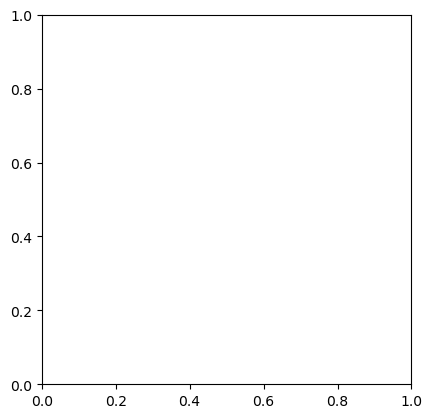

In [22]:
plt.figure()
plt.imshow(tf.math.log(batch[0]).numpy())

In [ ]:
#TODO data pre-processing: https://www.youtube.com/watch?v=jztwpsIzEGc&t=2002s


In [189]:
# Create neural network
input_shape = X_train.shape[:]

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 126, 32)      18176     
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 28, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 60928)            

In [54]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)

(60000, 28, 28)


In [39]:
hist = model.fit(X_train, y_train, epochs=60, validation_data=(X_test, y_test))

Epoch 1/60


2023-09-05 18:11:45.498192: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48577536 exceeds 10% of free system memory.


ValueError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 1506, 128, 63), found shape=(None, 128, 63)
